#### Text Vectorization Techniques
#### Bag Of Words, Topic Modeling and Word2vec

https://www.kaggle.com/c/word2vec-nlp-tutorial  
https://github.com/wendykan/DeepLearningMovies  
http://fastml.com/classifying-text-with-bag-of-words-a-tutorial/  


In this tutorial competition, we dig a little "deeper" into sentiment analysis. Google's Word2Vec is a deep-learning inspired method that focuses on the meaning of words. Word2Vec attempts to understand meaning and semantic relationships among words. It works in a way that is similar to deep approaches, such as recurrent neural nets or deep neural nets, but is computationally more efficient. This tutorial focuses on Word2Vec for sentiment analysis.

Sentiment analysis is a challenging subject in machine learning. People express their emotions in language that is often obscured by sarcasm, ambiguity, and plays on words, all of which could be very misleading for both humans and computers. There's another Kaggle competition for movie review sentiment analysis. In this tutorial we explore how Word2Vec can be applied to a similar problem.

Deep learning has been in the news a lot over the past few years, even making it to the front page of the New York Times. These machine learning techniques, inspired by the architecture of the human brain and made possible by recent advances in computing power, have been making waves via breakthrough results in image recognition, speech processing, and natural language tasks. Recently, deep learning approaches won several Kaggle competitions, including a drug discovery task, and cat and dog image recognition.

#### Let's charge the batteries for our analysis...

In [1]:
import os
import sys
import time
import pickle
from zipfile import ZipFile

import string
import re

import logging
import warnings

import pandas as pd
import numpy as np
import pylab
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

os.environ["NLTK_DATA"] = "/home/jovyan/work/2_virtual_classroom_materials/day_6_advanced_topics_RBI/data/nltk_data"
import nltk
#import nltk.data
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score as AUC

import gensim
from gensim import corpora
from gensim import models
from gensim import similarities
from gensim.models import Word2Vec

from bs4 import BeautifulSoup

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Data Set  
--

The labeled data set consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. The 25,000 review labeled training set does not include any of the same movies as the 25,000 review test set. In addition, there are another 50,000 IMDB reviews provided without any rating labels.

File descriptions

labeledTrainData - The labeled training set. The file is tab-delimited and has a header row followed by 25,000 rows containing an id, sentiment, and text for each review.  

testData - The test set. The tab-delimited file has a header row followed by 25,000 rows containing an id and text for each review. Your task is to predict the sentiment for each one. 

unlabeledTrainData - An extra training set with no labels. The tab-delimited file has a header row followed by 50,000 rows containing an id and text for each review. 

sampleSubmission - A comma-delimited sample submission file in the correct format.
Data fields

id - Unique ID of each review  
sentiment - Sentiment of the review; 1 for positive reviews and 0 for negative reviews  
review - Text of the review  

Loading the dataset:  
--

In [3]:
with ZipFile('./data/labeledTrainData.tsv.zip', 'r') as myzip:
    with myzip.open('labeledTrainData.tsv') as myfile:
        train = pd.read_csv(myfile, header=0, delimiter="\t", quoting=3)
        
with ZipFile('./data/testData.tsv.zip', 'r') as myzip:
    with myzip.open('testData.tsv') as myfile:
        test = pd.read_csv(myfile, header=0, delimiter="\t", quoting=3)
        
with ZipFile('./data/unlabeledTrainData.tsv.zip', 'r') as myzip:
    with myzip.open('unlabeledTrainData.tsv') as myfile:
        unlabeled_train = pd.read_csv(myfile, header=0, delimiter="\t", quoting=3)

In [4]:
fraction_dataset = 0.05

train = train.sample(frac=fraction_dataset, replace=False, random_state=1, ignore_index=True)
test = test.sample(frac=fraction_dataset, replace=False, random_state=1, ignore_index=True)
unlabeled_train = unlabeled_train.sample(frac=fraction_dataset, replace=False, random_state=1, ignore_index=True)

In [5]:
print("Read {} labeled train reviews, \
{} labeled test reviews, and \
{} unlabeled reviews\n".format(train["review"].size,
                               test["review"].size,
                               unlabeled_train["review"].size))

Read 1250 labeled train reviews, 1250 labeled test reviews, and 2500 unlabeled reviews



In [6]:
train.head()

,id,sentiment,review
0,"""2161_10""",1,"""How many of us wish that we could throw away ..."
1,"""4950_8""",1,"""Knowing when to end a movie is just as import..."
2,"""4942_7""",1,"""I have to admit that for the first half hour ..."
3,"""668_7""",1,"""I just watched \""The Last Wave\"" in my school..."
4,"""8689_7""",1,"""Perfect cast for a few-person drama. Simon is..."


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1250 non-null   object
 1   sentiment  1250 non-null   int64 
 2   review     1250 non-null   object
dtypes: int64(1), object(2)
memory usage: 29.4+ KB


In [8]:
train.describe()

,sentiment
count,1250.000000
mean,0.519200
std,0.499831
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


Part 1: For Beginners - Bag of Words
--
https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words  

What is NLP?

NLP (Natural Language Processing) is a set of techniques for approaching text problems. This page will help you get started with loading and cleaning the IMDB movie reviews, then applying a simple Bag of Words model to get surprisingly accurate predictions of whether a review is thumbs-up or thumbs-down.

In [9]:
class Text_Cleaning_Utilities(object):
    """Tools for processing text into segments for further learning"""

    @staticmethod
    def text_to_wordlist(text, 
                         remove_stopwords=False, 
                         remove_html=False, 
                         remove_non_letters=False, 
                         steeming=False):
        '''Split a text into a list of words'''
        #text = text.replace('-\n','')
        text = text.lower()
        if remove_html:
            text = BeautifulSoup(text, "html5lib").get_text()
        if remove_non_letters:
            text = re.sub("[^-A-Za-z0-9_]", " ", text)
        list_words = word_tokenize(text)
        list_words = [w.strip(string.punctuation) for w in list_words if w not in string.punctuation]
        list_words = [w for w in list_words if len(w) > 1]
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            list_words = [w for w in list_words if w not in stops]
        if steeming:
            stemmer = PorterStemmer()
            list_words = [stemmer.stem(item) for item in list_words]
        return list_words
    
    @staticmethod
    def df_to_list_of_texts(dataframe, column, 
                            remove_stopwords=False, 
                            remove_html=False, 
                            remove_non_letters=False, 
                            steeming=False):
        clean_texts = []
        for txt_id in range(len(dataframe[column])):
            clean_texts.append(' '.join(Text_Cleaning_Utilities.text_to_wordlist(dataframe[column][txt_id],
                                                                                 remove_stopwords=remove_stopwords,
                                                                                 remove_html=remove_html,
                                                                                 remove_non_letters=remove_non_letters,
                                                                                 steeming=steeming)))
            
        return clean_texts

    @staticmethod
    def df_to_list_of_tokens(dataframe, column, 
                             remove_stopwords=False, 
                             remove_html=False, 
                             remove_non_letters=False, 
                             steeming=False):
        clean_texts = []
        for txt_id in range(len(dataframe[column])):
            clean_texts.append(Text_Cleaning_Utilities.text_to_wordlist(dataframe[column][txt_id],
                                                                        remove_stopwords=remove_stopwords,
                                                                        remove_html=remove_html,
                                                                        remove_non_letters=remove_non_letters,
                                                                        steeming=steeming))
            
        return clean_texts

Cleaning all the datasets and getting word lists
--
first set is without stopwords

In [10]:
clean_train_reviews = Text_Cleaning_Utilities.df_to_list_of_texts(train, 
                                                                  'review', 
                                                                  remove_stopwords=True,
                                                                  remove_html=True,)
clean_test_reviews = Text_Cleaning_Utilities.df_to_list_of_texts(test, 
                                                                 'review', 
                                                                 remove_stopwords=True,
                                                                 remove_html=True,)

In [11]:
clean_train_reviews[0][0:80]

'many us wish could throw away social cultural obligations free us suspect shall '

In [12]:
clean_test_reviews[0][0:80]

"huge fan original operation delta force thought pick film figured could n't bad "

Second set mantains stopwords

In [13]:
clean_train_reviews_sw = Text_Cleaning_Utilities.df_to_list_of_texts(train, 
                                                                     'review',
                                                                     remove_html=True,)

clean_test_reviews_sw = Text_Cleaning_Utilities.df_to_list_of_texts(test, 
                                                                    'review',
                                                                    remove_html=True,)

In [14]:
clean_train_reviews_sw[0][0:80]

'how many of us wish that we could throw away social and cultural obligations and'

In [15]:
clean_test_reviews_sw[0][0:80]

'as huge fan of the original operation delta force thought pick this film up figu'

Creating Features from a Bag of Words (Using scikit-learn)
--

Now that we have our training reviews tidied up, how do we convert them to some kind of numeric representation for machine learning? One common approach is called a Bag of Words. The Bag of Words model learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears. For example, consider the following two sentences:

Sentence 1: "The cat sat on the hat"  
Sentence 2: "The dog ate the cat and the hat"  

From these two sentences, our vocabulary is as follows:

{ the, cat, sat, on, hat, dog, ate, and }

To get our bags of words, we count the number of times each word occurs in each sentence. In Sentence 1, "the" appears twice, and "cat", "sat", "on", and "hat" each appear once, so the feature vector for Sentence 1 is:

{ the, cat, sat, on, hat, dog, ate, and }

Sentence 1: [ 2, 1, 1, 1, 1, 0, 0, 0 ]

Similarly, the features for Sentence 2 are: [ 3, 1, 0, 0, 1, 1, 1, 1]

In the IMDB data, we have a very large number of reviews, which will give us a large vocabulary. To limit the size of the feature vectors, we should choose some maximum vocabulary size. Below, we use the 5000 most frequent words (remembering that stop words have already been removed).

We'll be using the feature_extraction module from scikit-learn to create bag-of-words features.  
We will test two strategies: CountVectorizer (term frequecies - TF) and TFIDF Vectorizer:  
First we'll start with plain word counts (TF):  

In [16]:
# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vectorizer_tf = CountVectorizer(input='content', 
                               encoding='utf-8', 
                               decode_error='strict', 
                               strip_accents=None, 
                               lowercase=True, 
                               preprocessor=None, 
                               tokenizer=None, 
                               stop_words=None, 
                               #token_pattern='(?u)\b\w\w+\b',
                               ngram_range=(1, 2),
                               analyzer='word', 
                               max_df=1.0, 
                               min_df=1, 
                               max_features=5000, 
                               vocabulary=None, 
                               binary=False, 
                               dtype=np.int64,
                              )

Fit_transform() does two functions: First, it fits the model and learns the vocabulary; 
second, it transforms our training data into feature vectors. 
The input to fit_transform should be a list of strings.

In [17]:
train_data_features_tf = vectorizer_tf.fit_transform(clean_train_reviews)
train_data_features_tf = train_data_features_tf.toarray() # Numpy arrays are easy to work with
print(train_data_features_tf.shape)

(1250, 5000)


In [18]:
test_data_features_tf = vectorizer_tf.fit_transform(clean_test_reviews)
test_data_features_tf = test_data_features_tf.toarray() # Numpy arrays are easy to work with
print(test_data_features_tf.shape)

(1250, 5000)


Now we are going to use TfIDf vectors and the train/test cleaned reviews with stopwords:

In [19]:
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
#Another approach using TfIDf vectorizer and using the texts with stopwords in:
#https://github.com/zygmuntz/classifying-text/blob/master/bow_predict.py 
vectorizer_tfidf = TfidfVectorizer(input='content',
                                  #encoding='utf-8',
                                  decode_error='strict',
                                  strip_accents=None,
                                  lowercase=True,
                                  preprocessor=None,
                                  tokenizer=None,
                                  analyzer='word',
                                  stop_words=None,
                                  #token_pattern='(?u)\b\w\w+\b',
                                  ngram_range=(1, 2),
                                  max_df=1.0,
                                  min_df=1,
                                  max_features=5000,
                                  vocabulary=None, 
                                  binary=False, 
                                  dtype=np.int64,
                                  norm='l2',
                                  use_idf=True,
                                  smooth_idf=True,
                                  sublinear_tf=True)

In [20]:
train_data_features_tfidf = vectorizer_tfidf.fit_transform(clean_train_reviews_sw)
train_data_features_tfidf = train_data_features_tfidf.toarray() # Numpy arrays are easy to work with
print(train_data_features_tfidf.shape)

(1250, 5000)


In [21]:
test_data_features_tfidf = vectorizer_tfidf.fit_transform(clean_test_reviews_sw)
test_data_features_tfidf = test_data_features_tfidf.toarray() # Numpy arrays are easy to work with
print(test_data_features_tfidf.shape)

(1250, 5000)


Dividing Train set for Cross Validation  
--

https://github.com/zygmuntz/classifying-text/blob/master/bow_validate.py  
Alternatively, we can use the indexes to divide the train samples  

train_i, test_i = train_test_split(np.arange(len(train)), train_size = 0.8, random_state = 44)  

After generating indexes, we can divide ou datasets:  
traincv = train_data_features1[train_i]  
testcv = train_data_features1[test_i]

In [22]:
#Plain Word Counts
X_traincv_tf, X_testcv_tf, y_traincv_tf, y_testcv_tf = model_selection.train_test_split(train_data_features_tf,
                                                                                        train["sentiment"],
                                                                                        test_size=0.2,
                                                                                        random_state=0)

In [23]:
#TfIdf
(X_traincv_tfidf, 
 X_testcv_tfidf, 
 y_traincv_tfidf, 
 y_testcv_tfidf) = model_selection.train_test_split(train_data_features_tfidf,
                                                    train["sentiment"],
                                                    test_size=0.2,
                                                    random_state=0)

Training some Classifiers  
--

At this point, we have numeric training features from the Bag of Words and the original sentiment labels for each feature vector, so let's do some supervised learning! Here, we'll use some classifiers implementations included in  the scikit-learn package.

#### Random Forest

In [24]:
# Initialize a Random Forest classifier with 300 trees
from sklearn.ensemble import RandomForestClassifier

clf_RF_tf = RandomForestClassifier(n_estimators=300, 
                                   criterion='gini', 
                                   max_depth=None, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, 
                                   max_features='auto', 
                                   max_leaf_nodes=None, 
                                   bootstrap=False, 
                                   oob_score=False, 
                                   n_jobs=-1, 
                                   random_state=0, 
                                   verbose=0, 
                                   warm_start=False, 
                                   class_weight=None).fit(X_traincv_tf, y_traincv_tf)

In [25]:
eval_RF_tf_tts = clf_RF_tf.score(X_testcv_tf, y_testcv_tf)
print(eval_RF_tf_tts)

0.796


In [26]:
clf_RF_tf.predict_proba(X_testcv_tf)

array([[0.40333333, 0.59666667],
       [0.49      , 0.51      ],
       [0.69666667, 0.30333333],
       [0.38666667, 0.61333333],
       [0.28333333, 0.71666667],
       [0.77666667, 0.22333333],
       [0.36      , 0.64      ],
       [0.59333333, 0.40666667],
       [0.37333333, 0.62666667],
       [0.33666667, 0.66333333],
       [0.43666667, 0.56333333],
       [0.60333333, 0.39666667],
       [0.51666667, 0.48333333],
       [0.55      , 0.45      ],
       [0.37      , 0.63      ],
       [0.47      , 0.53      ],
       [0.73      , 0.27      ],
       [0.82      , 0.18      ],
       [0.67333333, 0.32666667],
       [0.43333333, 0.56666667],
       [0.89      , 0.11      ],
       [0.55666667, 0.44333333],
       [0.61333333, 0.38666667],
       [0.23      , 0.77      ],
       [0.56      , 0.44      ],
       [0.61333333, 0.38666667],
       [0.17333333, 0.82666667],
       [0.61666667, 0.38333333],
       [0.33333333, 0.66666667],
       [0.62666667, 0.37333333],
       [0.

Now we are going to train on the TfIdf samples:

In [27]:
# Initialize a Random Forest classifier with 300 trees
clf_RF_tfidf = RandomForestClassifier(n_estimators=300, 
                                      criterion='gini', 
                                      max_depth=None, 
                                      min_samples_split=2, 
                                      min_samples_leaf=1, 
                                      min_weight_fraction_leaf=0.0, 
                                      max_features='auto', 
                                      max_leaf_nodes=None, 
                                      bootstrap=False, 
                                      oob_score=False, 
                                      n_jobs=-1, 
                                      random_state=0, 
                                      verbose=0, 
                                      warm_start=False, 
                                      class_weight=None).fit(X_traincv_tfidf, y_traincv_tfidf)

In [28]:
eval_RF_tfidf_tts = clf_RF_tfidf.score(X_testcv_tfidf, y_testcv_tfidf)
print(eval_RF_tfidf_tts)

0.804


In [29]:
clf_RF_tfidf.predict_proba(X_testcv_tfidf)

array([[0.56      , 0.44      ],
       [0.44      , 0.56      ],
       [0.64333333, 0.35666667],
       [0.28666667, 0.71333333],
       [0.53333333, 0.46666667],
       [0.64666667, 0.35333333],
       [0.37333333, 0.62666667],
       [0.47333333, 0.52666667],
       [0.31      , 0.69      ],
       [0.34666667, 0.65333333],
       [0.53      , 0.47      ],
       [0.61333333, 0.38666667],
       [0.53      , 0.47      ],
       [0.47333333, 0.52666667],
       [0.36      , 0.64      ],
       [0.50333333, 0.49666667],
       [0.67      , 0.33      ],
       [0.74333333, 0.25666667],
       [0.62666667, 0.37333333],
       [0.54      , 0.46      ],
       [0.84666667, 0.15333333],
       [0.33666667, 0.66333333],
       [0.60666667, 0.39333333],
       [0.3       , 0.7       ],
       [0.51      , 0.49      ],
       [0.65      , 0.35      ],
       [0.33      , 0.67      ],
       [0.57      , 0.43      ],
       [0.45333333, 0.54666667],
       [0.50333333, 0.49666667],
       [0.

#### Logistic Regression  

In [30]:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression as LR

clf_LR_tf = LR(penalty='l2',
               dual=False,
               tol=0.0001,
               C=1.0,
               fit_intercept=True,
               intercept_scaling=1,
               class_weight=None,
               random_state=0,
               solver='liblinear',
               max_iter=100,
               multi_class='ovr',
               verbose=0).fit(X_traincv_tf, y_traincv_tf)

In [31]:
eval_LR_tf_tts = clf_LR_tf.score(X_testcv_tf, y_testcv_tf)
print(eval_LR_tf_tts)

0.804


In [32]:
clf_LR_tfidf = LR(penalty='l2',
                  dual=False,
                  tol=0.0001,
                  C=1.0,
                  fit_intercept=True,
                  intercept_scaling=1,
                  class_weight=None,
                  random_state=0,
                  solver='liblinear',
                  max_iter=100,
                  multi_class='ovr',
                  verbose=0).fit(X_traincv_tfidf, y_traincv_tfidf)

In [33]:
eval_LR_tfidf_tts = clf_LR_tfidf.score(X_testcv_tfidf, y_testcv_tfidf)
print(eval_LR_tfidf_tts)

0.812


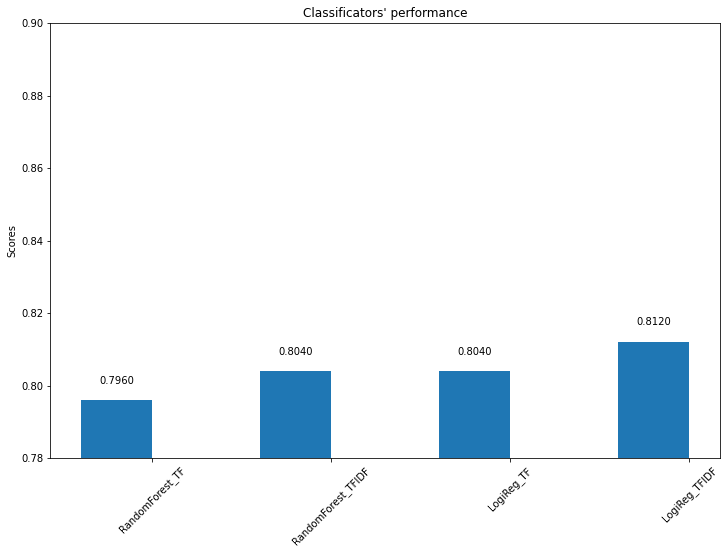

In [34]:
dic_results = {'RandomForest_TF': eval_RF_tf_tts,
               'RandomForest_TFIDF': eval_RF_tfidf_tts,
               'LogiReg_TF': eval_LR_tf_tts,
               'LogiReg_TFIDF': eval_LR_tfidf_tts,
              }

import operator
tup_results = sorted(dic_results.items(), key=operator.itemgetter(1))

N = len(dic_results)
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
rects = ax.bar(ind, list(zip(*tup_results))[1], width,)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., 
            1.005*height, 
            '{0:.4f}'.format(height), 
            ha='center', 
            va='bottom',)

ax.set_ylabel('Scores')
ax.set_ylim(ymin=0.78,ymax = 0.9)
ax.set_title("Classificators' performance")
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(list(zip(*tup_results))[0], rotation=45)

plt.show()

Creating a Submission  
--

All that remains is to run the best classifier on our test set and create a submission file. If you haven't already done so, download testData.tsv from the Data page. This file contains another 25,000 reviews and ids; our task is to predict the sentiment label.

Note that when we use the Bag of Words for the test set, we only call "transform", not "fit_transform" as we did for the training set. In machine learning, you shouldn't use the test set to fit your model, otherwise you run the risk of overfitting. For this reason, we keep the test set off-limits until we are ready to make predictions.

In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1250 non-null   object
 1   review  1250 non-null   object
dtypes: object(2)
memory usage: 19.7+ KB


In [36]:
test.head()

,id,review
0,"""5203_1""","""As a huge fan of the original Operation Delta..."
1,"""11917_10""","""oh boy !!! my god !!!! what a movie this one ..."
2,"""2973_8""","""I too saw this movie when it first came out. ..."
3,"""5671_3""","""I won't say the show is all bad, because ther..."
4,"""11566_1""","""In fact it was awful. The main chick in it wh..."


In [37]:
test_data_features_tfidf.shape

(1250, 5000)

In [38]:
# Use the logistic regression with tfidf vectors to make sentiment label predictions
result = clf_LR_tfidf.predict(test_data_features_tfidf)
result_prob = clf_LR_tfidf.predict_proba(test_data_features_tfidf)
output = pd.DataFrame(data={"id":test["id"], "sentiment":result,})# "probs":result_prob[:,1]})
# Use pandas to write the comma-separated output file
output.to_csv('./data/LR_tfidf_model.csv', index=False, quoting=3)

In [39]:
output.head()

,id,sentiment
0,"""5203_1""",1
1,"""11917_10""",1
2,"""2973_8""",1
3,"""5671_3""",1
4,"""11566_1""",1


Part 2: Alternative Vectors
--

In the subsequent sections, we are going to explore alternate ways to codify text into vectors. We are going to explore three techniques, namely Latent Semantic Indexing (LSI), Latent Dirichlet Allocation (LDA) and Word2vec.

### Topic Modeling and Topic Vectors

To build the models, the more we have texts, the better. The size of the Corpus is essential for having good results. We don't need labels in order to create the models, so we will use the train examples and also some unlabeled reviews. The list of cleaned sentences will be used for all the subsequent models.

In [40]:
print("Parsing sentences from training set")
labeled_sentences = Text_Cleaning_Utilities.df_to_list_of_tokens(train,
                                                                 'review', 
                                                                 remove_html=True,
                                                                 remove_stopwords=True,)
print("Parsing sentences from unlabeled set")
all_sentences = labeled_sentences + Text_Cleaning_Utilities.df_to_list_of_tokens(unlabeled_train,
                                                                                 'review', 
                                                                                 remove_html=True,
                                                                                 remove_stopwords=True,)

print("Parsing sentences from test set")
test_labeled_sentences = Text_Cleaning_Utilities.df_to_list_of_tokens(test,
                                                                      'review', 
                                                                      remove_html=True,
                                                                      remove_stopwords=True,)

print("Parsing sentences with stopwords from training set")
labeled_sentences_sw = Text_Cleaning_Utilities.df_to_list_of_tokens(train,
                                                                    'review', 
                                                                    remove_html=True,
                                                                    remove_stopwords=False,)

print("Parsing sentences with stopwords from unlabeled set")
all_sentences_sw = labeled_sentences_sw + Text_Cleaning_Utilities.df_to_list_of_tokens(unlabeled_train,
                                                                                       'review', 
                                                                                       remove_html=True,
                                                                                       remove_stopwords=False,)

print("Parsing sentences with stopwords from test set")
test_labeled_sentences_sw = Text_Cleaning_Utilities.df_to_list_of_tokens(test,
                                                                         'review', 
                                                                         remove_html=True,
                                                                         remove_stopwords=False,)

Parsing sentences from training set
Parsing sentences from unlabeled set
Parsing sentences from test set
Parsing sentences with stopwords from training set
Parsing sentences with stopwords from unlabeled set
Parsing sentences with stopwords from test set


In [41]:
print(len(labeled_sentences))
print(len(all_sentences))
print(len(test_labeled_sentences))
print(len(labeled_sentences_sw))
print(len(all_sentences_sw))
print(len(test_labeled_sentences_sw))

1250
3750
1250
1250
3750
1250


In [42]:
def nltk_stopwords():
    return set(nltk.corpus.stopwords.words('english'))

def prep_corpus(docs, additional_stopwords=set(), no_below=4, no_above=0.7):
    print('Building dictionary...')
    dictionary = corpora.Dictionary(docs)
    print('{} Tokens extracted from {} texts'.format(len(dictionary.keys()), dictionary.num_docs))
    stopwords = nltk_stopwords().union(additional_stopwords)
    #stopword_ids = [dictionary.token2id[sw] for sw in stopwords if sw in dictionary.token2id]
    stopword_ids = map(dictionary.token2id.get, stopwords)
    dictionary.filter_tokens(stopword_ids)
    #low_freq_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq < 4]
    #dictionary.filter_tokens(low_freq_ids)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    dictionary.compactify()
    print('{} Tokens after cleaning'.format(len(dictionary.keys())))
    #print('Building corpus...')
    #corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary #, corpus

Compacting and saving the dictionary

In [43]:
additional_stopwords=set(['n\'t', 'movie'])

dictionary = prep_corpus(all_sentences, additional_stopwords)
dictionary.compactify()
print('dictionary done')

dictionary.save('./data/reviews.dict')
print('dictionary saved')

Building dictionary...
43254 Tokens extracted from 3750 texts
10765 Tokens after cleaning
dictionary done
dictionary saved


In [44]:
#print(dictionary.token2id['movie']) #verify if these words were in the stopwords list
#print(dictionary.token2id['n\'t'])
print(dictionary.token2id['like'])

334


Loading dictionary

In [45]:
dictionary = corpora.dictionary.Dictionary.load('./data/reviews.dict')

Generating the Corpora (tf and tfidf)

In [46]:
corpus_tf = [dictionary.doc2bow(sentence) for sentence in all_sentences]
print('corpus tf done')
tfidf = models.TfidfModel(corpus_tf)
corpus_tfidf = tfidf[corpus_tf]
print('corpus tfidf done')

corpus tf done
corpus tfidf done


### Latent Semantic Indexing
https://en.wikipedia.org/wiki/Latent_semantic_analysis  

Generating the Models and the Corpora

In [47]:
lsi_tf = models.LsiModel(corpus_tf, id2word=dictionary, num_topics=10)
corpus_lsi_tf = lsi_tf[corpus_tf]
print('corpus lsi - TF done')
lsi_tfidf = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=10)
corpus_lsi_tfidf = lsi_tfidf[corpus_tfidf]
print('corpus lsi - TFIDF done')

corpus lsi - TF done
corpus lsi - TFIDF done


#### Visualizing the topics

In [48]:
lsi_tf.print_topics(10)

[(0,
  '0.513*"film" + 0.287*"one" + 0.218*"like" + 0.143*"would" + 0.143*"good" + 0.131*"even" + 0.123*"really" + 0.123*"time" + 0.115*"story" + 0.112*"see"'),
 (1,
  '-0.821*"film" + 0.198*"one" + 0.187*"like" + 0.122*"show" + 0.111*"movies" + 0.098*"good" + 0.097*"get" + 0.096*"would" + 0.093*"really" + 0.090*"even"'),
 (2,
  '0.699*"one" + -0.503*"like" + -0.160*"would" + -0.124*"people" + -0.118*"really" + -0.115*"bad" + 0.085*"two" + -0.083*"see" + -0.082*"good" + 0.076*"time"'),
 (3,
  '-0.422*"one" + -0.328*"bad" + -0.307*"like" + 0.245*"story" + 0.180*"life" + 0.177*"would" + -0.166*"really" + -0.152*"movies" + -0.116*"good" + 0.108*"man"'),
 (4,
  '0.567*"good" + -0.285*"like" + 0.267*"story" + 0.204*"really" + -0.186*"people" + 0.178*"great" + -0.175*"would" + -0.164*"one" + 0.142*"bad" + 0.134*"characters"'),
 (5,
  '0.482*"like" + -0.290*"bad" + -0.254*"would" + 0.234*"sam" + 0.217*"dean" + -0.187*"show" + 0.182*"story" + -0.170*"even" + 0.159*"great" + 0.157*"also"'),
 (6

In [49]:
lsi_tf.show_topic(1)

[('film', -0.8214762984099792),
 ('one', 0.19786518491243515),
 ('like', 0.18672354325107413),
 ('show', 0.1222467647940966),
 ('movies', 0.11122048853542961),
 ('good', 0.09834676873649496),
 ('get', 0.09744504677016358),
 ('would', 0.0961710905833087),
 ('really', 0.0931232182114836),
 ('even', 0.08991220448565104)]

In [50]:
lsi_tfidf.print_topics(10)

[(0,
  '0.152*"film" + 0.101*"good" + 0.100*"like" + 0.098*"really" + 0.098*"bad" + 0.093*"one" + 0.090*"would" + 0.088*"story" + 0.087*"see" + 0.087*"great"'),
 (1,
  '-0.269*"bad" + -0.188*"worst" + -0.116*"horrible" + -0.116*"ever" + -0.112*"funny" + -0.109*"acting" + -0.105*"movies" + -0.102*"waste" + -0.099*"terrible" + -0.095*"watch"'),
 (2,
  '0.617*"show" + 0.247*"series" + 0.174*"episode" + 0.160*"tv" + -0.160*"film" + 0.144*"episodes" + 0.142*"shows" + -0.140*"horror" + 0.115*"season" + -0.104*"bad"'),
 (3,
  '0.276*"great" + 0.251*"book" + -0.214*"show" + 0.116*"film" + 0.115*"actors" + -0.115*"horror" + 0.111*"read" + 0.100*"movies" + 0.100*"wonderful" + -0.097*"killer"'),
 (4,
  '0.267*"horror" + -0.250*"book" + 0.174*"series" + -0.140*"life" + -0.139*"people" + 0.135*"effects" + -0.119*"read" + 0.114*"special" + 0.112*"great" + 0.109*"original"'),
 (5,
  '-0.444*"book" + 0.266*"funny" + 0.246*"comedy" + -0.225*"series" + -0.209*"read" + -0.121*"original" + -0.114*"books" 

In [51]:
lsi_tfidf.show_topic(1)

[('bad', -0.2689210810364485),
 ('worst', -0.1884212522723442),
 ('horrible', -0.1164308197360946),
 ('ever', -0.11594577078959217),
 ('funny', -0.11171900178091068),
 ('acting', -0.10909461075508625),
 ('movies', -0.10450863750715143),
 ('waste', -0.10239010208408474),
 ('terrible', -0.09910889747801704),
 ('watch', -0.09480869056710979)]

### Latent Dirichlet Allocation

https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation  

#### Using Gensim

Generating the Models and the Corpora

In [52]:
lda_tf = models.LdaModel(corpus_tf, id2word=dictionary, num_topics=10, passes=10)
corpus_lda_tf = lda_tf[corpus_tf]
print('corpus lda tf done')

lda_tfidf = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=10, passes=10)
corpus_lda_tfidf = lda_tfidf[corpus_tfidf]
print('corpus lda tfidf done')

corpus lda tf done
corpus lda tfidf done


#### Visualizing the topics

In [53]:
lda_tf.print_topics(num_topics=10, num_words=7)

[(0,
  '0.019*"film" + 0.010*"one" + 0.006*"would" + 0.005*"like" + 0.005*"get" + 0.004*"see" + 0.003*"first"'),
 (1,
  '0.009*"man" + 0.006*"sam" + 0.005*"woman" + 0.005*"series" + 0.005*"murder" + 0.004*"one" + 0.004*"young"'),
 (2,
  '0.016*"like" + 0.014*"one" + 0.012*"good" + 0.012*"bad" + 0.010*"really" + 0.010*"would" + 0.009*"see"'),
 (3,
  '0.020*"film" + 0.009*"one" + 0.007*"story" + 0.004*"films" + 0.004*"great" + 0.004*"good" + 0.004*"like"'),
 (4,
  '0.007*"one" + 0.006*"action" + 0.006*"film" + 0.005*"also" + 0.005*"even" + 0.005*"well" + 0.004*"like"'),
 (5,
  '0.025*"series" + 0.015*"crawford" + 0.012*"joan" + 0.010*"arthur" + 0.005*"graham" + 0.005*"story" + 0.005*"anna"'),
 (6,
  '0.010*"one" + 0.007*"film" + 0.006*"like" + 0.005*"also" + 0.005*"woman" + 0.004*"good" + 0.004*"cop"'),
 (7,
  '0.019*"film" + 0.008*"one" + 0.008*"like" + 0.005*"good" + 0.005*"much" + 0.005*"would" + 0.005*"even"'),
 (8,
  '0.013*"film" + 0.010*"one" + 0.006*"story" + 0.005*"life" + 0.004

In [54]:
lda_tf.show_topic(5)

[('series', 0.024933074),
 ('crawford', 0.015101903),
 ('joan', 0.012061813),
 ('arthur', 0.009797324),
 ('graham', 0.0054370407),
 ('story', 0.0053737),
 ('anna', 0.004551899),
 ('powell', 0.00439501),
 ('young', 0.0039202236),
 ('holmes', 0.0038365459)]

In [55]:
lda_tfidf.print_topics(num_topics=10, num_words=7)
#lda_tfidf.print_topics(10)

[(0,
  '0.004*"gay" + 0.002*"cliché" + 0.002*"murphy" + 0.002*"shocking" + 0.002*"max" + 0.002*"matt" + 0.002*"massacre"'),
 (1,
  '0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"one" + 0.002*"bad" + 0.002*"really" + 0.002*"great"'),
 (2,
  '0.002*"beach" + 0.002*"welles" + 0.001*"rocket" + 0.001*"bell" + 0.001*"singing" + 0.001*"soldier" + 0.001*"deniro"'),
 (3,
  '0.002*"smith" + 0.002*"sandler" + 0.002*"wasted" + 0.002*"military" + 0.002*"teen" + 0.002*"laughed" + 0.002*"al"'),
 (4,
  '0.002*"ninja" + 0.002*"moon" + 0.002*"dolls" + 0.002*"addams" + 0.002*"mcdowell" + 0.002*"marlene" + 0.002*"someday"'),
 (5,
  '0.002*"crawford" + 0.002*"indie" + 0.002*"hindi" + 0.001*"previews" + 0.001*"notes" + 0.001*"huston" + 0.001*"flesh"'),
 (6,
  '0.002*"fairbanks" + 0.001*"kidnap" + 0.001*"rubin" + 0.001*"bunuel" + 0.001*"institute" + 0.001*"waited" + 0.001*"african-american"'),
 (7,
  '0.002*"roberts" + 0.002*"dutch" + 0.002*"carole" + 0.002*"poirot" + 0.002*"lombard" + 0.001*"crawford"

In [56]:
lda_tfidf.show_topics(formatted=False, num_words=20)[0:2]

[(0,
  [('gay', 0.003632257),
   ('cliché', 0.0022078815),
   ('murphy', 0.0020703946),
   ('shocking', 0.0019272104),
   ('max', 0.0016423697),
   ('matt', 0.0015288289),
   ('massacre', 0.0015284921),
   ('julia', 0.0015215717),
   ('teacher', 0.0015042572),
   ('creative', 0.0014460043),
   ('sarah', 0.0014029263),
   ('comedies', 0.001339309),
   ('britain', 0.001329276),
   ('somebody', 0.0013226969),
   ('mitchum', 0.0013208727),
   ('mummy', 0.0013148345),
   ('gold', 0.0013057688),
   ('holmes', 0.0013004207),
   ('i.e', 0.0012848581),
   ('twisted', 0.0012435127)]),
 (1,
  [('film', 0.003372825),
   ('good', 0.002232563),
   ('like', 0.0022049558),
   ('one', 0.00211721),
   ('bad', 0.0021093637),
   ('really', 0.0020821197),
   ('great', 0.0020334134),
   ('story', 0.002023062),
   ('would', 0.0019687964),
   ('see', 0.0019434566),
   ('time', 0.0018623293),
   ('even', 0.0018329847),
   ('could', 0.0018249645),
   ('people', 0.0018214819),
   ('movies', 0.0017998168),
   ('s

Visualizing using PyLDAvis  
http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb  

In [57]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

pyLDAvis.gensim_models.prepare(lda_tf, corpus_tf, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.041062  0.005836       1        1  28.192153
2      0.152349  0.019474       2        1  21.320579
8      0.046754  0.014814       3        1  14.492809
3      0.036337  0.005151       4        1   9.408517
0      0.032302 -0.001135       5        1   8.563814
9      0.028884 -0.003229       6        1   5.763453
4      0.046982  0.027691       7        1   5.191893
6     -0.004028 -0.072092       8        1   4.215061
1     -0.175888 -0.167431       9        1   1.810040
5     -0.204754  0.170921      10        1   1.041681, topic_info=        Term         Freq        Total Category  logprob  loglift
24      film  5612.000000  5612.000000  Default  30.0000  30.0000
921   series   448.000000   448.000000  Default  29.0000  29.0000
46       one  3823.000000  3823.000000  Default  28.0000  28.0000
1244     man   781.000000   781.000000  Default  27.0000  27.0000
197    story  1664.000000  1664.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
272   played    12.690059   366.009270  Topic10  -5.7482   1.2025
414   doctor     9.690056   121.932774  Topic10  -6.0180   2.0320
180     role     9.787185   514.430472  Topic10  -6.0080   0.6023
786       tv     9.670699   411.361108  Topic10  -6.0200   0.8140
833      son     9.295760   197.660845  Topic10  -6.0595   1.5073

[850 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
10741      9  0.859232    1965
7443       6  0.949925   aamir
6811       1  0.349587  accent
6811       2  0.139835  accent
6811       3  0.027967  accent
...      ...       ...     ...
467        9  0.060226   young
467       10  0.032120   young
6187       4  0.913926   zhang
6187       7  0.070302   zhang
3335       7  0.969301   zorro

[2379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 9, 4, 1, 10, 5, 7, 2, 6])

Making predictions with LDA vectors (we'll have to use only the labeled sentences):

In [58]:
#For predictions we need only the labeled set:
print("Creating Corpora for predictions")
corpus_tf2 = [dictionary.doc2bow(sentence) for sentence in labeled_sentences]
print('corpus tf done')

lda_tf2 = models.LdaModel(corpus_tf2, id2word=dictionary, num_topics=10, passes=10)
corpus_lda_tf2 = lda_tf2[corpus_tf2]
print('corpus lda tf done')

print('Creating lda vectors')
X = gensim.matutils.corpus2csc(corpus_lda_tf2)
X = X.T
print('lda vectors done')

Creating Corpora for predictions
corpus tf done
corpus lda tf done
Creating lda vectors
lda vectors done


In [59]:
X[0].todense()

matrix([[0.98859644, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]])

In [60]:
X_traincv_tf, X_testcv_tf, y_traincv_tf, y_testcv_tf = model_selection.train_test_split(X,
                                                                                        train["sentiment"],
                                                                                        test_size=0.2,
                                                                                        random_state=0)

In [61]:
from sklearn.linear_model import LogisticRegression as LR

clf_LR_tf_lda = LR(penalty='l2',
                   dual=False,
                   tol=0.0001,
                   C=1.0,
                   fit_intercept=True,
                   intercept_scaling=1,
                   class_weight=None,
                   random_state=0,
                   solver='liblinear',
                   max_iter=100,
                   multi_class='ovr',
                   verbose=0).fit(X_traincv_tf, y_traincv_tf)

In [62]:
eval_LR_tf_lda = clf_LR_tf_lda.score(X_testcv_tf, y_testcv_tf)
print(eval_LR_tf_lda)

0.528


### Distributed Word Vectors

https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors  

Introducing Distributed Word Vectors: This part of the tutorial will focus on using distributed word vectors created by the Word2Vec algorithm, using the Gensim implementation.  

https://radimrehurek.com/gensim/models/word2vec.html  

Word2vec, published by Google in 2013, is a neural network implementation that learns distributed representations for words. Other deep or recurrent neural network architectures had been proposed for learning word representations prior to this, but the major problem with these was the long time required to train the models. Word2vec learns quickly relative to other models.

Word2Vec does not need labels in order to create meaningful representations. This is useful, since most data in the real world is unlabeled. If the network is given enough training data (tens of billions of words), it produces word vectors with intriguing characteristics. Words with similar meanings appear in clusters, and clusters are spaced such that some word relationships, such as analogies, can be reproduced using vector math. The famous example is that, with highly trained word vectors, "king - man + woman = queen."

Distributed word vectors are powerful and can be used for many applications, particularly word prediction and translation. Here, we will try to apply them to sentiment analysis.

Using word2vec in Python: In Python, we will use the excellent implementation of word2vec from the gensim package. If you don't already have gensim installed, you'll need to install it. There is an excellent tutorial that accompanies the Python Word2Vec implementation, here.

Although Word2Vec does not require graphics processing units (GPUs) like many deep learning algorithms, it is compute intensive. Both Google's version and the Python version rely on multi-threading (running multiple processes in parallel on your computer to save time). ln order to train your model in a reasonable amount of time, you will need to install cython (instructions here). Word2Vec will run without cython installed, but it will take days to run instead of minutes. 

#### Preparing to Train a Model

We are going to use the whole set of sentences for training, the labeled and the unlabeled, which contains 50,000 additional reviews with no labels. When we built the Bag of Words model in Part 1, extra unlabeled training reviews were not useful. However, since Word2Vec can learn from unlabeled data, these extra 50,000 reviews can now be used.  

To train Word2Vec it is better not to remove stop words because the algorithm relies on the broader context of the sentence in order to produce high-quality word vectors.

#### Training and Saving Your Model  

With the list of nicely parsed sentences, we're ready to train the model. There are a number of parameter choices that affect the run time and the quality of the final model that is produced. For details on the algorithms below, see the word2vec API documentation as well as the Google documentation. 

Architecture: Architecture options are skip-gram (default) or continuous bag of words. We found that skip-gram was very slightly slower but produced better results.

Training algorithm: Hierarchical softmax (default) or negative sampling. For us, the default worked well.

Downsampling of frequent words: The Google documentation recommends values between .00001 and .001. For us, values closer 0.001 seemed to improve the accuracy of the final model.

Word vector dimensionality: More features result in longer runtimes, and often, but not always, result in better models. Reasonable values can be in the tens to hundreds; we used 300.

Context / window size: How many words of context should the training algorithm take into account? 10 seems to work well for hierarchical softmax (more is better, up to a point).

Worker threads: Number of parallel processes to run. This is computer-specific, but between 4 and 6 should work on most systems.

Minimum word count: This helps limit the size of the vocabulary to meaningful words. Any word that does not occur at least this many times across all documents is ignored. Reasonable values could be between 10 and 100. In this case, since each movie occurs 30 times, we set the minimum word count to 40, to avoid attaching too much importance to individual movie titles. This resulted in an overall vocabulary size of around 15,000 words. Higher values also help limit run time.

Choosing parameters is not easy, but once we have chosen our parameters, creating a Word2Vec model is straightforward:

In [63]:
# Import the built-in logging module and configure it so that Word2Vec creates nice output messages
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [64]:
num_features = 300    # Word vector dimensionality
min_word_count = 5   # Minimum word count
num_workers = -1       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-5   # Downsample setting for frequent words

In [65]:
# Initialize and train the model (this will take some time)
model = Word2Vec(all_sentences_sw,
                 workers = num_workers,
                 vector_size = num_features,
                 min_count = min_word_count, 
                 window = context,
                 sample = downsampling,
                 seed=1,)

2022-05-18 14:16:52,016 : INFO : collecting all words and their counts
2022-05-18 14:16:52,017 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-05-18 14:16:52,198 : INFO : collected 43387 word types from a corpus of 816941 raw words and 3750 sentences
2022-05-18 14:16:52,199 : INFO : Creating a fresh vocabulary
2022-05-18 14:16:52,254 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 10265 unique words (23.66% of original 43387, drops 33122)', 'datetime': '2022-05-18T14:16:52.253956', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) \n[GCC 9.4.0]', 'platform': 'Linux-4.14.276-211.499.amzn2.x86_64-x86_64-with-debian-buster-sid', 'event': 'prepare_vocab'}
2022-05-18 14:16:52,254 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 766302 word corpus (93.80% of original 816941, drops 50639)', 'datetime': '2022-05-18T14:16:52.254854', 'gensim': '4.2.0', 'python': '3.7.1

In [66]:
##Optionally converting the model for Bigrams (to capture more context):
bigram_transformer = gensim.models.Phrases(all_sentences_sw)
model = Word2Vec(bigram_transformer[all_sentences_sw],
                 workers = num_workers,
                 vector_size = num_features,
                 min_count = min_word_count, 
                 window = context,
                 sample = downsampling,
                 seed=1,)

2022-05-18 14:16:52,486 : INFO : collecting all words and their counts
2022-05-18 14:16:52,488 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2022-05-18 14:16:53,539 : INFO : collected 391016 token types (unigram + bigrams) from a corpus of 816941 words and 3750 sentences
2022-05-18 14:16:53,540 : INFO : merged Phrases<391016 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2022-05-18 14:16:53,541 : INFO : Phrases lifecycle event {'msg': 'built Phrases<391016 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000> in 1.05s', 'datetime': '2022-05-18T14:16:53.541327', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) \n[GCC 9.4.0]', 'platform': 'Linux-4.14.276-211.499.amzn2.x86_64-x86_64-with-debian-buster-sid', 'event': 'created'}
2022-05-18 14:16:53,543 : INFO : collecting all words and their counts
2022-05-18 14:16:53,544 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
20

In [67]:
logging.getLogger('').setLevel(logging.ERROR)

In [68]:
# If you don't plan to train the model any further, calling init_sims will make the model much more memory-efficient.
model.wv.fill_norms()

Exploring the Model Results

Congratulations on making it successfully through everything so far! Let's take a look at the model we created out of our 75,000 training reviews.

The "doesnt_match" function will try to deduce which word in a set is most dissimilar from the others:

In [69]:
print(model.wv.doesnt_match("captain onion starship alien".split()))
print(model.wv.doesnt_match("father mother son daughter film".split()))
print(model.wv.doesnt_match("france england germany berlin".split()))
print(model.wv.most_similar("man"))
print(model.wv.most_similar("queen"))
print(model.wv.most_similar("awful"))

alien
daughter
france
[('on_hbo', 0.22268562018871307), ('absolutely_nothing', 0.2186601310968399), ('gothic', 0.2185399830341339), ('miller', 0.21110859513282776), ('martial_arts', 0.20782388746738434), ('greatness', 0.20282837748527527), ('steadily', 0.19514214992523193), ('hatred', 0.1910945177078247), ('klein', 0.1887647956609726), ('formal', 0.18504518270492554)]
[('characters', 0.22363445162773132), ('u.s', 0.2162657231092453), ('revolutionary', 0.21171391010284424), ('inmates', 0.20882846415042877), ('sung_by', 0.20228241384029388), ('hawaii', 0.18297584354877472), ('derive', 0.182753324508667), ('effectively', 0.1823064237833023), ('announced', 0.18072237074375153), ('1981', 0.1799950897693634)]
[('endless', 0.20211930572986603), ('jolly', 0.1900801956653595), ('spontaneous', 0.18662548065185547), ('non', 0.17841736972332), ('brats', 0.1777513474225998), ('blatant', 0.17736709117889404), ('barker', 0.17700155079364777), ('gag', 0.17608344554901123), ('beloved', 0.17487458884716

So it seems we have a reasonably good model for semantic meaning - at least as good as Bag of Words. But how can we use these fancy distributed word vectors for supervised learning? The next section takes a stab at that.

Part 3: More Fun With Word Vectors
--

https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-3-more-fun-with-word-vectors  

Numeric Representations of Words

Now that we have a trained model with some semantic understanding of words, how should we use it? If you look beneath the hood, the Word2Vec model trained in Part 2 consists of a feature vector for each word in the vocabulary, stored in a numpy array called "syn0":

In [70]:
model.wv.vectors.shape

(11858, 300)

The number of rows in syn0 is the number of words in the model's vocabulary, and the number of columns corresponds to the size of the feature vector, which we set in Part 2.  Setting the minimum word count to 40 gave us a total vocabulary of 16,492 words with 300 features apiece. Individual word vectors can be accessed in the following way:

In [71]:
model.wv["flower"][0:10]

array([ 1.5171679e-03, -2.3923111e-03,  7.8737736e-05,  2.6374864e-03,
       -1.8806243e-03,  1.8973422e-03, -3.8731814e-04,  2.4518650e-04,
        6.8122149e-04, -1.7461363e-03], dtype=float32)

In [72]:
model.wv.index_to_key[0:10]

['the', 'and', 'of', 'to', 'is', 'it', 'in', 'that', 'this', 'was']

## From Words To Paragraphs,
### Attempt 1: Vector Averaging

One challenge with the IMDB dataset is the variable-length reviews. We need to find a way to take individual word vectors and transform them into a feature set that is the same length for every review.

Since each word is a vector in 300-dimensional space, we can use vector operations to combine the words in each review. One method we tried was to simply average the word vectors in a given review (for this purpose, we removed stop words, which would just add noise).

The following code averages the feature vectors, building on our code from Part 2.

In [73]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given paragraph
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,), dtype=float)
    nwords = 0.
    # Index2word is a list that contains the names of the words in the model's vocabulary. 
    #Convert it to a set, for speed
    index2word_set = set(model.wv.index_to_key)
    # Loop over each word in the review and, if it is in the model's
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model.wv[word])
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [74]:
def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate
    # the average feature vector for each one and return a 2D numpy array
    # Initialize a counter
    counter = 0.
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # Loop through the reviews
    for review in reviews:
        # Print a status message every 2000th review
        if counter%2000. == 0.:
            print("Review {} of {}".format(counter, len(reviews)))
        #Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, num_features)
        counter = counter + 1.
    return reviewFeatureVecs

Now, we can call these functions to create average vectors for each paragraph. The following operations will take a few minutes:

In [75]:
# Calculate average feature vectors for training and testing sets, using the functions 
# we defined above. Notice that we now use stop word removal.
trainDataVecs = getAvgFeatureVecs(labeled_sentences_sw, model, num_features)

Review 0.0 of 1250


In [76]:
trainDataVecs[100][0:10]

array([ 6.5228414e-05,  3.0249506e-04,  1.8169235e-04,  4.9329101e-05,
       -1.4669850e-04, -4.3263612e-04,  6.5841916e-05,  5.5383920e-04,
       -3.2464231e-04, -2.0554307e-04], dtype=float32)

Check for Nan values:

In [77]:
print(np.isnan(trainDataVecs).any()) #testando se não há valores que inviabilizam o treinamento
print(np.isfinite(trainDataVecs).all())

False
True


In [78]:
# If there are Nan values we can use inputer  
from sklearn.impute import SimpleImputer as Imputer
trainDataVecs = Imputer().fit_transform(trainDataVecs)

In [79]:
print(np.isnan(trainDataVecs).any()) 
print(np.isfinite(trainDataVecs).all())

False
True


Next, use the average paragraph vectors with the classifiers from Part 1.  
Note that, as in Part 1, we can only use the labeled training reviews to train the model.

In [80]:
X_traincvWV, X_testcvWV, y_traincvWV, y_testcvWV = model_selection.train_test_split(trainDataVecs,
                                                                                    train["sentiment"],
                                                                                    test_size=0.2,
                                                                                    random_state=0)

In [81]:
# Initialize a Random Forest classifier with 300 trees
from sklearn.ensemble import RandomForestClassifier

clf_RF_WV = RandomForestClassifier(n_estimators=300, 
                                   criterion='gini', 
                                   max_depth=None, 
                                   min_samples_split=3, 
                                   min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, 
                                   max_features='auto', 
                                   max_leaf_nodes=None, 
                                   bootstrap=False, 
                                   oob_score=False, 
                                   n_jobs=-1, 
                                   random_state=None, 
                                   verbose=0, 
                                   warm_start=False, 
                                   class_weight=None).fit(X_traincvWV, y_traincvWV)

eval_RF_WV_tts = clf_RF_WV.score(X_testcvWV, y_testcvWV)
print(eval_RF_WV_tts)

0.628


In [82]:
from sklearn.linear_model import LogisticRegression as LR

clf_LR_WV = LR(penalty='l2',
               dual=False,
               tol=0.0001,
               C=1.0,
               fit_intercept=True,
               intercept_scaling=1,
               class_weight=None,
               random_state=None,
               solver='liblinear',
               max_iter=100,
               multi_class='ovr',
               verbose=0).fit(X_traincvWV, y_traincvWV)

eval_LR_WV_tts = clf_LR_WV.score(X_testcvWV, y_testcvWV)
print(eval_LR_WV_tts)

0.456


## Creating a Submission

In [83]:
testDataVecs = getAvgFeatureVecs(test_labeled_sentences, model, num_features)

Review 0.0 of 1250


In [84]:
print(np.isnan(testDataVecs).any()) 
print(np.isfinite(testDataVecs).all())

False
True


In [85]:
testDataVecs = Imputer().fit_transform(testDataVecs)

print(np.isnan(testDataVecs).any()) 
print(np.isfinite(testDataVecs).all())

False
True


In [86]:
testDataVecs[0][0:10]

array([-1.69379069e-04, -4.18808086e-05,  1.33924390e-04, -1.10707486e-04,
       -7.29216990e-05,  1.47403131e-04,  1.07962114e-04, -3.27756366e-04,
        1.01574456e-04,  7.08282969e-05], dtype=float32)

In [87]:
# Use the random forest to make sentiment label predictions
result = clf_RF_WV.predict(testDataVecs)
result_prob = clf_RF_WV.predict_proba(testDataVecs)
print(result[0:10])
print(result_prob[0:10])

[0 1 1 1 0 1 0 1 1 1]
[[0.57833333 0.42166667]
 [0.43166667 0.56833333]
 [0.44833333 0.55166667]
 [0.48166667 0.51833333]
 [0.50166667 0.49833333]
 [0.48833333 0.51166667]
 [0.53       0.47      ]
 [0.475      0.525     ]
 [0.49333333 0.50666667]
 [0.49666667 0.50333333]]


In [88]:
output = pd.DataFrame(data={"id":test["id"], "sentiment":result,})# "probs":result_prob[:,1]})
# Use pandas to write the comma-separated output file
output.to_csv('./data/Word2Vec_AverageVectors.csv', index=False, quoting=3)

In [89]:
output.head()

,id,sentiment
0,"""5203_1""",0
1,"""11917_10""",1
2,"""2973_8""",1
3,"""5671_3""",1
4,"""11566_1""",0


We found that this produced results much better than chance, but underperformed Bag of Words by a few percentage points.

Since the element-wise average of the vectors didn't produce spectacular results, perhaps we could do it in a more intelligent way? A standard way of weighting word vectors is to apply "tf-idf" weights, which measure how important a given word is within a given set of documents. One way to extract tf-idf weights in Python is by using scikit-learn's TfidfVectorizer, which has an interface similar to the CountVectorizer that we used in Part 1. However, when we tried weighting our word vectors in this way, we found no substantial improvement in performance.

## From Words to Paragraphs, Attempt 2: Clustering
Word2Vec creates clusters of semantically related words, so another possible approach is to exploit the similarity of words within a cluster. Grouping vectors in this way is known as "vector quantization." To accomplish this, we first need to find the centers of the word clusters, which we can do by using a clustering algorithm such as K-Means.

In K-Means, the one parameter we need to set is "K," or the number of clusters. How should we decide how many clusters to create? Trial and error suggested that small clusters, with an average of only 5 words or so per cluster, gave better results than large clusters with many words. Clustering code is given below. We use scikit-learn to perform our K-Means.

K-Means clustering with large K can be very slow; the following code took more than 40 minutes on my computer. Below, we set a timer around the K-Means function to see how long it takes.

In [90]:
start = time.time()

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an average of 5 words per cluster
word_vectors = model.wv.vectors
print(word_vectors.shape)

num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters,
                           n_init=5,
                           verbose=2,
                           #n_jobs=-2,
                           random_state=0)

idx = kmeans_clustering.fit_predict(word_vectors) # trimmed last line because of an error

elapsed = time.time() - start
print("Time taken for K Means clustering: ", elapsed, "seconds.")

(11858, 300)
Initialization complete
Iteration 0, inertia 16.268474578857422
Iteration 1, inertia 9.641810417175293
Iteration 2, inertia 9.639556884765625
Iteration 3, inertia 9.63915729522705
Iteration 4, inertia 9.63909912109375
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 16.266820907592773
Iteration 1, inertia 9.641510009765625
Iteration 2, inertia 9.63865852355957
Iteration 3, inertia 9.638092041015625
Iteration 4, inertia 9.63801097869873
Iteration 5, inertia 9.637880325317383
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 16.269073486328125
Iteration 1, inertia 9.651985168457031
Iteration 2, inertia 9.650073051452637
Iteration 3, inertia 9.649685859680176
Iteration 4, inertia 9.649396896362305
Iteration 5, inertia 9.649317741394043
Iteration 6, inertia 9.649259567260742
Converged at iteration 6: strict convergence.
Initialization complete
Iteration 0, inertia 16.274368286132812
Iteration 1,

In [91]:
# Create a Word / Index dictionary, mapping each vocabulary word to a cluster number
word_centroid_map = dict(zip(model.wv.index_to_key, idx))

This is a little abstract, so let's take a closer look at what our clusters contain.  
Your clusters may differ, as Word2Vec relies on a random number seed.  
Here is a loop that prints out the words for clusters 0 through 9:

Run k-means on the word vectors and print a few clusters

In [92]:
# Print the first ten clusters
for cluster in range(0,10):
    # Print the cluster number
    print("\nCluster {}".format(cluster))
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0,len(word_centroid_map.values())):
        #print(len(word_centroid_map.values()))
        #print(cluster)
        #print(word_centroid_map.keys())
        if(list(word_centroid_map.values())[i] == cluster):
            words.append(list(word_centroid_map.keys())[i])
    print(words)


Cluster 0
['scenery', 'graveyard']

Cluster 1
['smash']

Cluster 2
['were', '10', 'running_around', '30', 'disturbed', 'nostalgic', 'citizens', 'severely']

Cluster 3
['lately', 'directs', 'psychopath', 'stacey']

Cluster 4
['b-movie', 'lights', 'uncertainty']

Cluster 5
['innocent', '2006', 'ages', 'population', 'bone', 'switches', 'guaranteed', 'bourgeois']

Cluster 6
['forced', 'go_through', 'terrified', 'skillfully']

Cluster 7
['street', 'hutton', '1992']

Cluster 8
['loose', 'tell_me', 'pan', 'steaming_pile', 'p.s']

Cluster 9
['anyone', 'noted', 'characterisation', 'prisoner', 'firemen']


We can see that the clusters are of varying quality. Some make sense, some cointain mostly names, and some contain related adjectives. On the other hand, some are a little mystifying. Perhaps our algorithm works best on adjectives.

At any rate, now we have a cluster (or "centroid") assignment for each word, and we can define a function to convert reviews into bags-of-centroids. This works just like Bag of Words but uses semantically related clusters instead of individual words:

In [93]:
def create_bag_of_centroids(wordlist, word_centroid_map):
    # The number of clusters is equal to the highest cluster index in the word / centroid map
    num_centroids = max(word_centroid_map.values()) + 1
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    return bag_of_centroids

The function above will give us a numpy array for each review, each with a number of features equal to the number of clusters. Finally, we create bags of centroids for our training and test set, then train a random forest and extract results:

In [94]:
# ****** Create bags of centroids

# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros((train["review"].size, num_clusters), dtype="float32")

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

In [95]:
X_traincvCT, X_testcvCT, y_traincvCT, y_testcvCT = model_selection.train_test_split(train_centroids,
                                                                                    train["sentiment"],
                                                                                    test_size=0.2,
                                                                                    random_state=0)

In [96]:
# Initialize a Random Forest classifier with 100 trees
clf_RF_CT = RandomForestClassifier(n_estimators=100, 
                                   criterion='gini', 
                                   max_depth=None, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, 
                                   max_features='auto', 
                                   max_leaf_nodes=None, 
                                   bootstrap=True, 
                                   oob_score=False, 
                                   n_jobs=1, 
                                   random_state=None, 
                                   verbose=0, 
                                   warm_start=False, 
                                   class_weight=None).fit(X_traincvCT, y_traincvCT)

In [97]:
eval_RF_CT_tts = clf_RF_CT.score(X_testcvCT, y_testcvCT)
print(eval_RF_CT_tts)

0.456


In [101]:
# Repeat for test reviews
test_centroids = np.zeros((test["review"].size, num_clusters), dtype="float32")

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

In [99]:
result = clf_RF_CT.predict(test_centroids)

# Write the test results
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv("./data/BagOfCentroids.csv", index=False, quoting=3)
print("Wrote BagOfCentroids.csv")

Wrote BagOfCentroids.csv


/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
/opt/conda/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To sil

We found that the code above gives about the same (or slightly worse) results compared to the Bag of Words in Part 1.

## Part 4: Comparing deep and non-deep learning methods
You may ask: Why is Bag of Words better?

The biggest reason is, in our tutorial, averaging the vectors and using the centroids lose the order of words, making it very similar to the concept of Bag of Words. The fact that the performance is similar (within range of standard error) makes all three methods practically equivalent.

A few things to try:

First, training Word2Vec on a lot more text should greatly improve performance. Google's results are based on word vectors that were learned out of more than a billion-word corpus; our labeled and unlabeled training sets together are only a measly 18 million words or so. Conveniently, Word2Vec provides functions to load any pre-trained model that is output by Google's original C tool, so it's also possible to train a model in C and then import it into Python.

Second, in published literature, distributed word vector techniques have been shown to outperform Bag of Words models. In this paper, an algorithm called Paragraph Vector is used on the IMDB dataset to produce some of the most state-of-the-art results to date. In part, it does better than the approaches we try here because vector averaging and clustering lose the word order, whereas Paragraph Vectors preserves word order information.

What is Deep Learning?

The term "deep learning" was coined in 2006, and refers to machine learning algorithms that have multiple non-linear layers and can learn feature hierarchies [1].

Most modern machine learning relies on feature engineering or some level of domain knowledge to obtain good results. In deep learning systems, this is not the case -- instead, algorithms can automatically learn feature hierarchies, which represent objects in increasing levels of abstraction. Although the basic ingredients of many deep learning algorithms have been around for many years, they are currently increasing in popularity for many reasons, including advances in compute power, the falling cost of computing hardware, and advances in machine learning research.

Deep learning algorithms can be categorized by their architecture (feed-forward, feed-back, or bi-directional) and training protocols (purely supervised, hybrid, or unsupervised) [2].

Some good background materials include:

[1] "Deep Learning for Signal and Information Processing", by Li Deng and Dong Yu (out of Microsoft)

[2] "Deep Learning Tutorial" (2013 Presentation by Yann LeCun and Marc'Aurelio Ranzato)

Where Does Word2Vec Fit In?

Word2Vec works in a way that is similar to deep approaches such as recurrent neural nets or deep neural nets, but it implements certain algorithms, such as hierarchical softmax, that make it computationally more efficient.

See Part 2 of this tutorial for more on Word2Vec, as well as this paper: Efficient Estimation of Word Representations in Vector Space

In this tutorial, we use a hybrid approach to training -- consisting of an unsupervised piece (Word2Vec) followed by supervised learning (the Random Forest).